In [46]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from functions import get_baskets, get_coupons, get_prediction_index, get_3_files
from functions import split_4_way
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading datasets

In [5]:
baskets, coupons, prediction_index = get_3_files()
customers = (1950,2000)
n_customers = customers[1] - customers[0]
baskets = baskets[(baskets['customer'] > customers[0]) & (baskets['customer'] < customers[1])]

# Creating: Universal base

In [6]:
def create_base(weeks=range(90), customers=range(2000)):
    products = range(250)
    n_weeks, n_customers, n_products = len(weeks), len(customers), len(products)

    base = pd.DataFrame({
    'week': np.array([[x] * n_products * n_customers for x in weeks]).flatten(),
    'customer': np.array([[x] * n_products for x in customers] * n_weeks).flatten(),
    'product': list(range(n_products)) * n_customers * n_weeks
    })
    
    return base

# Adding: Basket information

In [7]:
def add_basket_info(base, baskets):
    base = pd.merge(base, baskets, on=['week', 'customer','product'], how='left')
    base['price'] = base['price'].fillna(0).astype(int)
    base['isBought'] = (base['price'] > 0)
    base['basket'] = base['week'].astype(str) + '_' + base['customer'].astype(str)
    return base

# Adding: Coupon information

In [8]:
def add_coupon_info(base, baskets, coupons):
    base = pd.merge(base, coupons, on=['week', 'customer','product'], how='left')
    base['discount'] = base['discount'].fillna(0).astype(int)
    base = base.rename(columns={"discount": "dGiven"})
    base['isGiven'] = (base['dGiven'] > 0)

    normal_prices = baskets.groupby('product')['price'].max().values
    base['highestPrice'] = base['product'].apply(lambda x: normal_prices[x])
    base['isUsed'] = ((base['price'] != base['highestPrice']) & (base['price']!=0))
    base.drop('highestPrice', axis=1, inplace=True)
    return base

# Finding: Categories

In [9]:
base = create_base(customers=range(1990,2000))
base = add_basket_info(base,baskets)

n_baskets = base['basket'].nunique()

matrix = np.matrix([np.array(base.iloc[x*250:x*250+250,:].loc[:,'isBought']) for x in range(n_baskets)]).astype(int)

<AxesSubplot:>

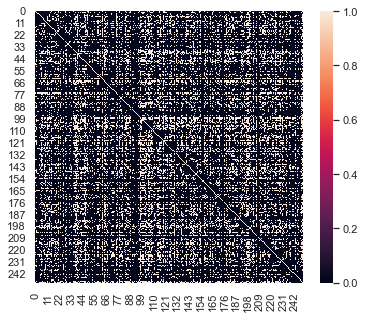

In [10]:
occurency_matrix = matrix.T.dot(matrix)
occurency_matrix[occurency_matrix > 1] = 1

sns.set(rc={'figure.figsize':(6,5)})
sns.heatmap(occurency_matrix, annot=False)
#plt.savefig('co_occurency_matrix_full.png')

<AxesSubplot:>

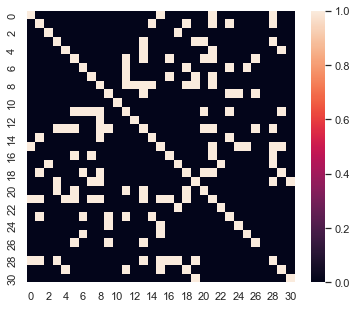

In [11]:
sns.heatmap(occurency_matrix[:31,:31], annot=False)
#plt.savefig('co_occurency_matrix_part.png')

# Adding: Categories

In [12]:
def add_categories(base):
    base['category'] = (base['product'] / 10).astype(int)
    return base

# Adding: Probabilities (product & category)

In [13]:
baskets

,week,customer,product,price
14881,0,1951,1,560
14882,0,1951,28,442
14883,0,1951,42,527
14884,0,1951,53,672
14885,0,1951,60,795
...,...,...,...,...
68091869,89,1999,144,562
68091870,89,1999,158,566
68091871,89,1999,192,549
68091872,89,1999,213,592


In [34]:
def add_frequencies(base, baskets, until, n_weeks=90):
    
    baskets = baskets[baskets['week']<=until]
    
    baskets.loc[:,'category'] = (baskets['product'].astype(int) / 10).astype(int)
    
    prod_probs_df = (
        baskets.groupby(['customer','product'])['week'].count() / n_weeks) \
        .reset_index() \
        .rename(columns={'week':'probability'})

    cat_probs_df = (
        baskets.groupby(['customer','category'])['week'].count() / n_weeks) \
        .reset_index() \
        .rename(columns={'week':'probability'})
        
    base = pd.merge(base, prod_probs_df, on=['customer','product'] ,how='left')
    base = pd.merge(base, cat_probs_df, on=['customer','category'] ,how='left')
    
    base.rename(columns={'probability_x':'p_prod', 'probability_y':'p_cat'},inplace=True)
    
    base[['p_prod','p_cat']] = base[['p_prod','p_cat']].fillna(0)
    
    return base

# Adding: Rolling frequencies

In [15]:
def get_rolling_frequencies(n_weeks=5, category=False):
    
    rolling_df = pd.DataFrame()
    
    for week_nr in range(n_weeks,89+1):

        start = week_nr - n_weeks - 1
        end = week_nr

        single_week = (
            base[(start < base['week']) & (base['week'] < end)] 
            .groupby(['customer',f"{'category' if category else 'product'}"]) 
            .agg({'week':'last','isBought':'sum'}) 
            .reset_index()
            )
        
        single_week['week'] = single_week['week'] + 1
        single_week['isBought'] = single_week['isBought'] / n_weeks
        rolling_df = pd.concat([rolling_df, single_week])
    
    return rolling_df

In [16]:
def add_rolling_frequencies(base):
    
    values = [5,10,30]
    prod_names = [f'roll_prod_{value}' for value in values]
    cat_names  = [f'roll_cat_{value}' for value in values]

    for i, name in enumerate(prod_names):
        rolled = get_rolling_frequencies(n_weeks=values[i]).rename(columns={'isBought':name})
        base = pd.merge(base, rolled, on=['week','customer','product'],how='left')

    for i, name in enumerate(cat_names):
        rolled = get_rolling_frequencies(n_weeks=values[i], category=True).rename(columns={'isBought':name})
        base2 = pd.merge(base, rolled, on=['week','customer','category'],how='left') 
        
    base.loc[:,prod_names[0]:] = base2.loc[:,prod_names[0]:].fillna(0)  
    
    return base

# Adding: Weeks since last buy (per product and per category)

In [17]:
def buy_weeks_to_ago(buy_weeks):
    weeks_past = 90
    val = []
    bought = False

    for i in range(90):
        if i in buy_weeks:
            weeks_past = 0
            val.append(weeks_past)
            bought = True
        elif(bought==True): 
            weeks_past += 1 
            val.append(weeks_past)
        else:
            val.append(90)
    return val

In [18]:
def add_weeks_ago(base):
    
    only_bought = base[base['isBought']==1]
    pairs = only_bought.groupby(['customer','product']).size().reset_index(inplace=False)

    all_pairs = pd.DataFrame()

    for i in range(len(pairs)):
        customer = pairs.iloc[i,0]
        product = pairs.iloc[i,1]
        
        df = pd.DataFrame({
            'week':range(90),
            'customer':customer, 
            'product':product, 
            })
        
        buy_weeks = list(only_bought[(only_bought['product']==product) & (only_bought['customer']==customer)]['week'])
        df['weeks_ago'] = buy_weeks_to_ago(buy_weeks)
        all_pairs = pd.concat([all_pairs,df])
        
    base = pd.merge(base, all_pairs, on=['week','customer','product'],how='left').fillna(90)
    
    return base

# Actually creating bases

In [48]:
ranger = range(1800,2000)

## Training base

In [49]:
base = create_base(customers=ranger,weeks=range(89))
base = add_basket_info(base, baskets)
base = add_coupon_info(base, baskets, coupons)
base = add_categories(base)
base = add_frequencies(base, baskets, until=88,n_weeks=89)
#base = add_rolling_frequencies(base)
#base = add_weeks_ago(base)
base = base.drop(['price', 'basket','isUsed'], axis=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


## Testing base

In [50]:
base_test = create_base(customers=ranger,weeks=range(89,89+1))
base_test = add_categories(base_test)
base_test['dGiven'] = 0
base_test['isGiven'] = False
base_test = add_frequencies(base_test, baskets, 88, 89)

In [51]:
y_test = create_base(customers=ranger,weeks=range(89,89+1))
y_test = add_basket_info(y_test, baskets)['isBought'].values

# Modelling

In [52]:
x_train = base.drop('isBought',axis=1)
y_train = base['isBought']

x_test = base_test
y_test = y_test

In [53]:
#model1 = linear_model.LogisticRegression()
models = [
    ensemble.BaggingClassifier(), #5.7%
    ensemble.AdaBoostClassifier(), #3.8%
    ensemble.ExtraTreesClassifier(), #3.6%  
    ensemble.RandomForestClassifier(), #2.6%
    ensemble.GradientBoostingClassifier(), #1.9%
    ensemble.HistGradientBoostingClassifier() #2.4%
] 

In [54]:
#forbidden_columns = ['price','isUsed']
#x_train, y_train, x_test, y_test = split_4_way(base.drop(forbidden_columns, axis=1), target_col='isBought', unkwown_week=89)

for i, model in enumerate(models):
    
    print(f'Model {i}: {model}')
    
    model.fit(X = x_train, y = y_train)
    predictions = model.predict_proba(x_test)
    cross_entropy_loss = metrics.log_loss(y_test, predictions)
    
    print(f'Loss: {round(cross_entropy_loss,3)}\n')

Model 0: BaggingClassifier()
Loss: 0.057

Model 1: AdaBoostClassifier()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Loss: 0.381

Model 2: ExtraTreesClassifier()
Loss: 0.036

Model 3: RandomForestClassifier()
Loss: 0.026

Model 4: GradientBoostingClassifier()
Loss: 0.019

Model 5: HistGradientBoostingClassifier()
Loss: 0.024

